# Establishing relation TB to ice thickness
## introduction
The training data was generated in Huntemann et al. 2014. it consist of modeled ice thickness increase from a cumulative freezeing degree day model for the freezeup in 2010 in a Kara and Barents Seas. 
In this document we are using the sama data from SMOS and the cumulative freezing degree day model to fit an analytic equation to the dependency of brightness temperature and ice thickness. In contrast to Huntemann et al. 2014, here instead of the Intensity and Polarization difference, the horizontal and vertical polarized brightness temperatures are used directly.

## The dataset
The dataset was aquired in 2010 in the Kara and Barents Seas. The dataset here is treated differently compared to Huntemann et al. 2014 in two points
* From initial 10 small subregions only 3,6, and 7 was used to obtain the original fit parameters, here all regions are kept
* The original retrieval removed the 0cm ice thickness, i.e., open water cases in the fit, due to instability in fitting procedure for the polarization difference $Q$, these points are included here

```{note}
The extraction of brightness tempertarue for the fit procedure and algortihm development had to be reevaluated at an incidence angle of 53° for this document since the incidence angle for previous fit attempts where different with Huntemann et al, 2014 being 40°-50° average, and Paţilea et al. 2019 using 40°.
```




In [1]:
using Pkg
Pkg.activate("../sit_atbd_env_jl")
using Plots
using CSV
using LaTeXStrings
using Printf
using DataFrames
#using Distributions
using LsqFit
using Markdown
using Printf
import YAML
using Statistics
import GMT

  Activating project at `~/SeaIceThickness_ATBD/sit_atbd_env_jl`


In [2]:
all_regions_locs=
[  7.6849991e+001,  4.2563492e+001],
[  7.8344194e+001,  4.7455311e+001],
[  7.8714499e+001,  5.7407954e+001],
[  7.8378661e+001,  6.6654149e+001],
[  7.8337631e+001,  7.4859558e+001],
[  7.7374017e+001,  8.1712057e+001],
[  7.5811001e+001,  7.9569564e+001],
[  7.4850015e+001,  6.9278851e+001],
[  7.3124055e+001,  6.1770532e+001],
[  7.1849906e+001,  6.0701303e+001]

([76.849991, 42.563492], [78.344194, 47.455311], [78.714499, 57.407954], [78.378661, 66.654149], [78.337631, 74.859558], [77.374017, 81.712057], [75.811001, 79.569564], [74.850015, 69.278851], [73.124055, 61.770532], [71.849906, 60.701303])

#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region01_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region02_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region03_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region04_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region05_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region06_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region07_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region08_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region09_53.txt"
#= In[159]:5 =# @sprintf("../data/region%02i_53.txt", i) = "../data/region10_53.txt"


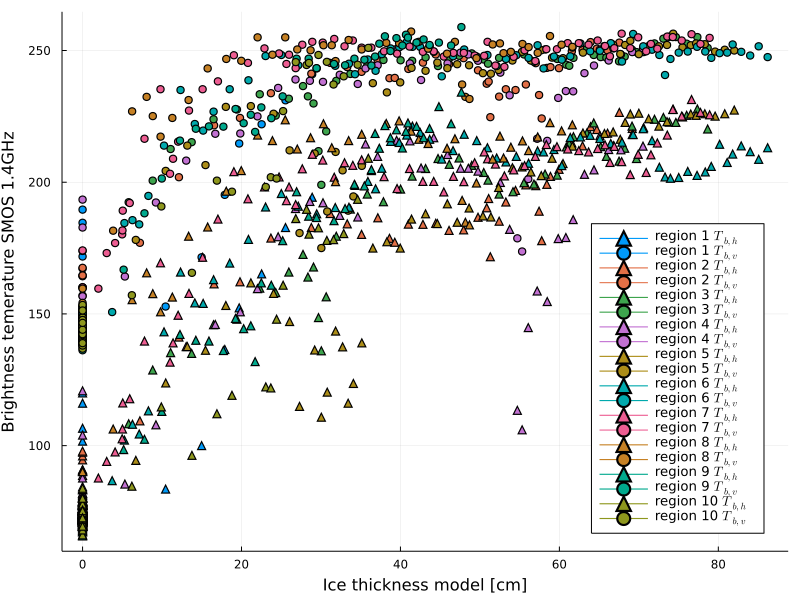

In [90]:
airt=CSV.read("../data/sit_ncep.txt",DataFrame,limit=87)
all_regions_dfs=DataFrame[]
plot(size=(800,600))
for i=1:10
#    @show @sprintf "../data/region%02i_53.txt" i
    push!(all_regions_dfs,CSV.read((@sprintf "../data/region%02i_53.txt" i),DataFrame))
end

plot!
for i=1:10
scatter!(airt[!,"region$i"],all_regions_dfs[i].TBh,m=:utriangle,lw=0,c=i,label=false)#L"region %$i $T_{b,h}")
scatter!(airt[!,"region$i"],all_regions_dfs[i].TBv,m=:circ,lw=0,c=i,label="region $i")
end


plot!(legend=:bottomright)
plot!(legendfontsize=10)
xlabel!("Ice thickness model [cm]")
ylabel!("Brightness temerature SMOS 1.4GHz")

scatter!([1],[0],marker=:utriangle,color="black",label=L"$T_{b,h}$")
scatter!([1],[0],marker=:circ,color="black",label=L"$T_{b,v}$")
ylims!(50,260)

The {numref}`fig:tbsmos` gives a nice relation beween ice thickness and the brightness temperatures in horizontal and vertical polarization. Horizontal shows a slower increase and later saturation but is subject to more noise in general. For the fitting procedure $0\ \text{cm}$ ice thickness, i.e. open water, is excluded.

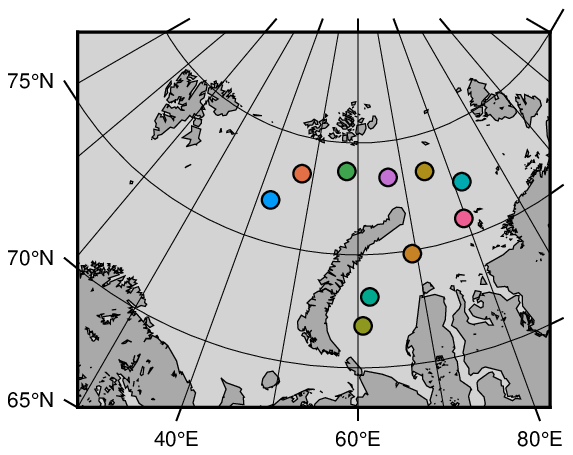

In [48]:
GMT.coast(region="30/65/120/80+r", proj=(name=:stereographic, center=(60,90)), 
    xaxis=(annot=20,grid=10),
    yaxis=(annot=5,ticks=0,grid=5),
    res=:auto,
      area=2, land=:darkgray, shore=:thinnest, water=:lightgray, figsize=4,
    par=(FONT_ANNOT_PRIMARY=5,MAP_ANNOT_ORTHO=:we)
)

cs=["lightblue","orange","darkgreen"]
for i=1:10
GMT.psxy!(all_regions_locs[i][2],all_regions_locs[i][1],size=0.15,markerfacecolor="#"*hex(theme_palette(:auto)[i]),markeredgecolor="black")
end
GMT.showfig()

In [55]:
alltbh=collect(skipmissing(vcat([all_regions_dfs[i].TBh for i=1:10]...)))
nanidx=isnan.(alltbh)

alltbv=collect(skipmissing(vcat([all_regions_dfs[i].TBv for i=1:10]...)))
allsit=vcat([airt[!,"region$i"] for i=1:10]...);


#nanidx.|=(allsit.==0)


alltbh=alltbh[.!nanidx]
alltbv=alltbv[.!nanidx]
allsit=allsit[.!nanidx];


## fitting parameter estimation
As a fit function a simple exponential is used with 

$$
f_p(x)= p_2 - (p_2 - p_1)\exp(-x/p_3)
$$ (eq:intensity)

where $p_1$ is effectively the brightness temperature of open water close to sea ice under freezing areas under freezing conditions, $p_2$ is the brightness temerature of thick sea ice, and $p_3$ is a curvature parameter connecting the two TBs. The index $p$ of $f_p$ indicates the polarization, either $h$ or $v$.


The parameters $p_i$ are optained in a fit to the data from the three regions mentioned. 
A least square fit of equation {eq}`eq:intensity` for $T_{b,h}$ and $T_{b,v}$ individually gives 6 parameters in total.
The same can be done in intensity and polarization difference space while for polarization difference another fit formula is used

$$
f_Q(x)= p_2 - (p_2 -p_1)\exp(-(x/p_3)^{p_4})
$$ (eq:poldiff)

another least square fit for the 7 parameters in {eq}`eq:poldiff` is performed.

In [50]:
@. ff(x,p)=p[2]-(p[2]-p[1])*exp(-x/p[3])
@. fq(x,p)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])
ph=curve_fit(ff,allsit,alltbh,[70.0,200.0,0.12]).param
pv=curve_fit(ff,allsit,alltbv,[70.0,200.0,0.12]).param
pI=curve_fit(ff,allsit,alltbh./2+alltbv./2,[70.0,200.0,0.12]).param
pQ=curve_fit(fq,allsit,alltbv.-alltbh,[70.0,20.0,0.12,0.4]).param
t(n)=@sprintf "%.3f" n

"""```{table} Fit parameters for intensity and polarization difference
:name: "retrieval parameters"

| polarization\\parameter | \$p_1\$ | \$p_2\$ | \$p_3\$ | \$p_4\$ |
| --- | --- | --- | --- | --- | 
| horizontal \$T_{b,h}\$ | $(t(ph[1])) | $(t(ph[2])) | $(t(ph[3])) |   |
| vertical \$T_{b,v}\$| $(t(pv[1])) | $(t(pv[2])) | $(t(pv[3])) |    |
| intensity \$I=(T_{b,v}+T_{b,h})/2\$| $(t(pI[1])) | $(t(pI[2])) | $(t(pI[3])) |    |
| polarization difference \$I=(T_{b,v}-T_{b,h})\$| $(t(pQ[1])) | $(t(pQ[2])) | $(t(pQ[3])) | $(t(pQ[4])) | 
""" * "```"|> Markdown.parse 

```{table} Fit parameters for intensity and polarization difference
:name: "retrieval parameters"

| polarization\parameter | $p_1$ | $p_2$ | $p_3$ | $p_4$ |
| --- | --- | --- | --- | --- | 
| horizontal $T_{b,h}$ | 75.172 | 217.283 | 20.723 |   |
| vertical $T_{b,v}$| 145.359 | 247.861 | 12.302 |    |
| intensity $I=(T_{b,v}+T_{b,h})/2$| 110.311 | 231.499 | 16.583 |    |
| polarization difference $I=(T_{b,v}-T_{b,h})$| 70.674 | 35.237 | 38.259 | 2.199 | 
```


## comparison between $I-Q$ and $h-v$ fit
A resulting fit through all datapoints show that also the direct horizontal and vertical fits are suitable for representation of ice thickness to brightness temperature relation.

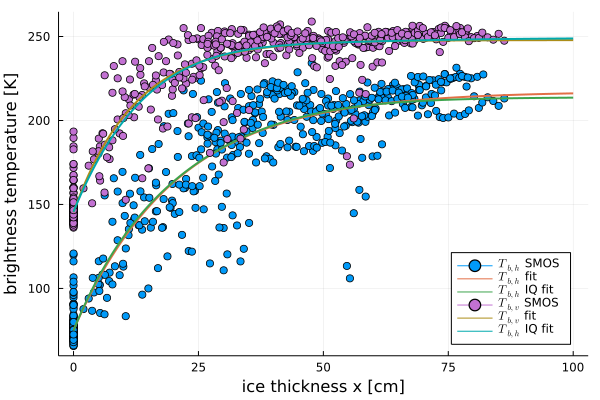

In [51]:
xx=0:0.1:100.0

plot(allsit,alltbh,lw=0,markershape=:circle,label=L"$T_{b,h}$ SMOS")
plot!(xx,ff(xx,ph),lw=2,label=L"$T_{b,h}$ fit")
plot!(xx,ff(xx,pI).-fq(xx,pQ)./2,lw=2,label=L"$T_{b,h}$ IQ fit")

plot!(allsit,alltbv,lw=0,markershape=:circle,label=L"$T_{b,v}$ SMOS")
plot!(xx,ff(xx,pv),legend=:bottomright,lw=2,label=L"$T_{b,v}$ fit")
plot!(xx,ff(xx,pI).+fq(xx,pQ)./2,lw=2,label=L"$T_{b,h}$ IQ fit")


xlabel!("ice thickness x [cm]")
ylabel!("brightness temperature [K]")

showing the relation fo polarization difference $T_{b,v} - T_{b,h}$ to ice thickness shows also good agreement with the data in both fit variants.

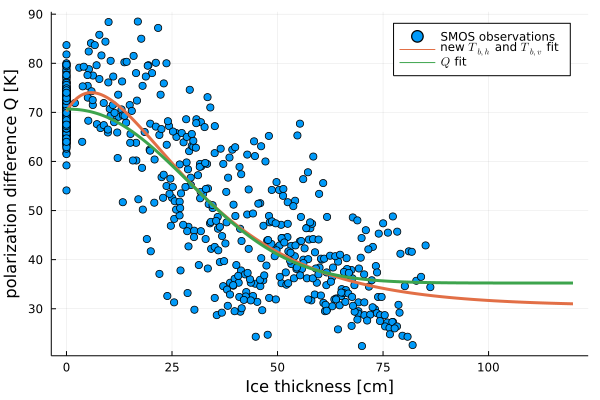

In [88]:
xx=0:0.01:120
scatter(allsit,alltbv.-alltbh, m=:circ, label="SMOS observations")
plot!(xx,ff(xx,pv).-ff(xx,ph),lw=3,label=L"new $T_{b,h}$ and $T_{b,v}$ fit")
plot!(xx,fq(xx,pQ),lw=3,label=L"$Q$ fit")

ylabel!("polarization difference Q [K]")
xlabel!("Ice thickness [cm]")

The polarization difference plotted versus intensity, which is the original representation used by Huntemann et al. 2014 and Paţilea et al. 2019 also shows that the fit is appropriate in the $I-Q$-space

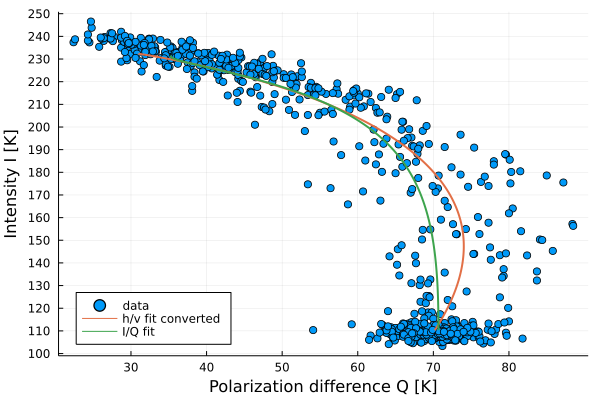

In [53]:
scatter(alltbv.-alltbh,alltbv./2 +alltbh./2,label="data")
plot!(ff(xx,pv).-ff(xx,ph),ff(xx,pv)./2 .+ff(xx,ph)./2,lw=2,label="h/v fit converted")
plot!(fq(xx,pQ),ff(xx,pI),lw=2,label="I/Q fit")

xlabel!("Polarization difference Q [K]")
ylabel!("Intensity I [K]")
xticks!(20:10:80)
yticks!(100:10:250,legend=:bottomleft)

In [89]:
YAML.write_file("fit_params.yml", Dict("ph"=>ph,"pv"=>pv, "pI"=>pI, "pQ"=>pQ))